# Facial keypoint detection

## Data preparation

In [1]:
!mkdir ./data
!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip;
!unzip -nq ./data/train-test-data.zip -d ./data;
!rm ./data/train-test-data.zip;

--2021-04-12 14:02:40--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘./data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  4.82MB/s    in 61s     

2021-04-12 14:03:42 (5.26 MB/s) - ‘./data/train-test-data.zip’ saved [338613624/338613624]



In [ ]:
ls ./data/

test/  test_frames_keypoints.csv  training/  training_frames_keypoints.csv


Сlass KeypointDataset seeking the coordinates of keypoints in the folder with images.

In [2]:
!mv ./data/test_frames_keypoints.csv ./data/test/
!mv ./data/training_frames_keypoints.csv ./data/training/

## Data inspection

Counting the number of images.

In [3]:
import os
from torchvision.datasets.folder import IMG_EXTENSIONS

def find_images(path):
    with os.scandir(path) as it:
        files = []
        for entry in it:
            fname, ext = os.path.splitext(entry.name)

            if ext in IMG_EXTENSIONS:
                files.append(os.path.join(path, entry.name))

    return files

train_files = find_images('./data/training')
test_files = find_images('./data/test')   

print(('Train data: {}, Test data: {}').format(
    len(train_files), len(test_files)))# except csv

Train data: 3462, Test data: 2308


In [4]:
import pandas as pd

train_keypoints = pd.read_csv('./data/training/training_frames_keypoints.csv')
test_keypoints = pd.read_csv('./data/test/test_frames_keypoints.csv')

In [ ]:
train_keypoints.shape

(3462, 137)

In [ ]:
train_keypoints.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


Find the mean and standard deviation of the sample of keypoints for standardization keypoints.

In [5]:
coordinates = test_keypoints.drop(columns='Unnamed: 0')

X = coordinates[coordinates.columns[::2]]# all x coordinates
Y = coordinates[coordinates.columns[1::2]]# all y coordinates
mean = X.mean().mean(), Y.mean().mean()
std = X.stack().std(), Y.stack().std()
print(f'Mean: {mean}\nStandard deviation: {std}')

Mean: (98.65106951871658, 110.12295645530946)
Standard deviation: (41.72860410125119, 42.92496672693624)


In [ ]:
test_keypoints.shape

(770, 137)

In [ ]:
test_keypoints.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,64.0,27.0,67.0,30.0,71.0,33.0,75.0,39.0,76.0,46.0,76.0,52.0,74.0,56.0,72.0,59.0,67.0,62.0,62.0,63.0,57.0,64.0,52.0,65.0,47.0,27.0,40.0,30.0,39.0,32.0,...,33.0,65.0,36.0,64.0,38.0,64.0,39.0,65.0,41.0,64.0,44.0,65.0,47.0,65.0,44.0,66.0,42.0,68.0,39.0,68.0,37.0,68.0,36.0,66.0,33.0,65.0,38.0,65.0,39.0,65.0,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,101.0,57.0,108.0,60.0,114.0,65.0,121.0,75.0,127.0,88.0,124.0,98.0,122.0,106.0,117.0,114.0,112.0,122.0,102.0,124.0,94.0,129.0,87.0,129.0,76.0,57.0,52.0,60.0,50.0,65.0,...,65.0,101.0,68.0,101.0,70.0,98.0,75.0,101.0,78.0,101.0,83.0,104.0,88.0,106.0,83.0,109.0,78.0,109.0,73.0,109.0,70.0,109.0,68.0,106.0,65.0,101.0,70.0,104.0,75.0,104.0,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,127.0,73.0,135.0,78.0,137.0,83.0,140.0,96.0,143.0,109.0,138.0,119.0,135.0,127.0,130.0,132.0,125.0,135.0,115.0,135.0,105.0,137.0,95.0,137.0,84.0,63.0,75.0,65.0,70.0,71.0,...,78.0,119.0,83.0,114.0,89.0,112.0,91.0,112.0,94.0,112.0,101.0,112.0,109.0,117.0,101.0,120.0,96.0,122.0,94.0,122.0,89.0,122.0,83.0,122.0,81.0,119.0,89.0,117.0,91.0,114.0,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,128.0,64.0,135.0,73.0,139.0,83.0,144.0,96.0,144.0,105.0,137.0,107.0,133.0,107.0,127.0,109.0,120.0,109.0,112.0,109.0,103.0,109.0,95.0,107.0,86.0,60.0,83.0,66.0,79.0,73.0,...,83.0,122.0,90.0,120.0,94.0,116.0,98.0,116.0,100.0,116.0,103.0,116.0,103.0,118.0,103.0,122.0,100.0,125.0,98.0,127.0,94.0,127.0,90.0,124.0,83.0,122.0,94.0,120.0,96.0,118.0,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,96.0,51.0,103.0,58.0,108.0,66.0,112.0,76.0,112.0,85.0,107.0,91.0,100.0,94.0,93.0,96.0,84.0,96.0,77.0,96.0,70.0,96.0,64.0,94.0,55.0,42.0,67.0,48.0,65.0,51.0,...,60.0,94.0,64.0,96.0,69.0,94.0,73.0,94.0,74.0,94.0,80.0,94.0,83.0,93.0,80.0,98.0,78.0,101.0,73.0,101.0,69.0,101.0,66.0,99.0,60.0,94.0,69.0,96.0,73.0,96.0,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


Show example of keypoints.

In [6]:
kpts = train_keypoints[train_keypoints['Unnamed: 0'] == 'Agbani_Darego_52.jpg']
kpts = kpts.drop('Unnamed: 0', axis=1).to_numpy().reshape(68, 2).astype('uint8')
kpts

array([[ 88, 114],
       [ 84, 128],
       [ 80, 147],
       [ 80, 158],
       [ 80, 176],
       [ 84, 191],
       [ 88, 206],
       [ 95, 224],
       [110, 239],
       [132, 236],
       [147, 229],
       [161, 218],
       [176, 204],
       [187, 189],
       [195, 178],
       [202, 167],
       [209, 149],
       [ 99, 110],
       [106, 110],
       [117, 118],
       [125, 122],
       [128, 129],
       [161, 141],
       [172, 141],
       [180, 141],
       [191, 141],
       [198, 145],
       [139, 155],
       [132, 166],
       [128, 181],
       [125, 188],
       [117, 184],
       [117, 192],
       [125, 195],
       [132, 195],
       [136, 192],
       [102, 132],
       [110, 132],
       [117, 136],
       [125, 144],
       [117, 144],
       [106, 136],
       [158, 155],
       [169, 155],
       [176, 156],
       [184, 159],
       [176, 163],
       [165, 159],
       [ 99, 195],
       [106, 199],
       [117, 199],
       [121, 203],
       [128,

There are 68 points in total. Let's show image with keypoints.

In [7]:
import matplotlib.pyplot as plt

def show_keypoints(image, kpts, mean=(0, 0), std=(1, 1)):

    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    
    plt.scatter(kpts[:, 0] * std[0] + mean[0],
                kpts[:, 1] * std[1] + mean[1], s=50, marker='.', c='k')

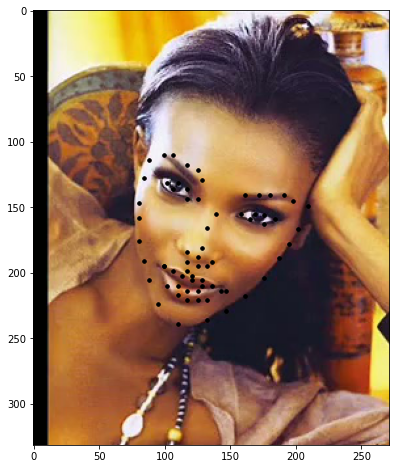

In [8]:
from PIL import Image

img = Image.open('./data/training/Agbani_Darego_52.jpg')
show_keypoints(img, kpts)

# Model development

I have defined a way of loading the dataset and transforming data into preprocessing.py and next I create loaders for training and test data. All transforms get a pair from image and keypoints.

In [11]:
from os.path import join
from torchvision.transforms import Compose
from preprocessing import (KeypointDataset, Resized, CenterCropped, ToTensored,
                           Normalized, RandomHorizontalFlipped)
from torch.utils.data import DataLoader

tform = {'training': Compose([Resized((224, 224)),
                              CenterCropped((224, 224)),
                              # RandomHorizontalFlipped(0.5),
                              ToTensored(),
                              Normalized(kpts_mean=mean,
                                         kpts_std=std)
                             ]),
         'test': Compose([Resized((224, 224)),
                          CenterCropped(224),
                          ToTensored(),
                          Normalized(kpts_mean=mean,
                                     kpts_std=std)])}

root = './data'
dataset = {x: KeypointDataset(join(root, x), tform[x]) for x in tform.keys()}
loaders = {x: DataLoader(dataset[x],
                         batch_size=8,
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True,
                         drop_last=False) for x in tform.keys()}

I will create a simple convolutional network.

In [12]:
from torch import cuda
from torch.nn import Module, Conv2d, MaxPool2d, Linear, Dropout
from torch.nn.functional import relu


class KeypointDetector(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 64, 3, stride=2)
        self.conv2 = Conv2d(64, 64, 3, stride=2)
        self.pool1 = MaxPool2d(2, stride=2)

        self.conv3 = Conv2d(64, 64, 3, stride=2)
        self.conv4 = Conv2d(64, 128, 3, stride=2)
        self.pool2 = MaxPool2d(2, stride=2)

        self.fc1 = Linear(1152, 272)
        self.fc2 = Linear(272, 136)

        self.drop = Dropout(0.25)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = self.pool1(x)

        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = x.view(x.size(0), -1, 2)
        return x

model = KeypointDetector()

use_cuda = cuda.is_available()
if use_cuda:
    model = model.cuda()
print(f'Using cuda: {use_cuda}')

Using cuda: True


In [13]:
from torchsummary import summary
summary(model, loaders['training'].dataset.__getitem__(0)[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
            Conv2d-2           [-1, 64, 55, 55]          36,928
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4           [-1, 64, 13, 13]          36,928
            Conv2d-5            [-1, 128, 6, 6]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
           Dropout-7                 [-1, 1152]               0
            Linear-8                  [-1, 272]         313,616
           Dropout-9                  [-1, 272]               0
           Linear-10                  [-1, 136]          37,128
Total params: 500,248
Trainable params: 500,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.99
Params size (MB): 1.91
Estimated T

I will add an auxiliary function to determine the timing of training and testing functions.

In [14]:
import time
import functools


def timed(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.time()
        name = func.__name__
        class_name = func.__class__.__name__
        print(f'{class_name} {name} stared at: {time.ctime(t0)}')

        result = func(*args, **kwargs)

        t = time.time() - t0
        print(f'{class_name} {name} ended at: {time.ctime(t + t0)}.\n\
Elapsed time:{t:.5f} sec')

        return result
    return wrapper

In [15]:
from torch import save

@timed
def train(model, loaders, criterion, optimizer, epochs, scheduler=None):
    n_batches = (len(loaders['training'].dataset) / 
        loaders['training'].batch_size)

    model.train()
    min_loss = 2**64
    for epoch in range(epochs):
        epoch_loss = 0.0
        for ix, (img, kpts) in enumerate(loaders['training']):
            if use_cuda:
                img = img.cuda()
                kpts = kpts.cuda()

            optimizer.zero_grad()

            loss = criterion(model(img), kpts)
            loss.backward()
            epoch_loss += loss.item()

            optimizer.step()

        epoch_loss /= n_batches
        print(f'Epoch{epoch} loss: {epoch_loss}')

        if scheduler is not None:
            scheduler.step()

# Training & Testing

I will use stochastic gradient descent for training and mean square error to estimate the adequacy of the model.

In [16]:
from torch.optim import SGD
from torch.nn import MSELoss, L1Loss, SmoothL1Loss
from torch.optim.lr_scheduler import StepLR


criterion = MSELoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=70, gamma=0.5)

In [ ]:
epochs = 80
model = model.cuda()
train(model, loaders, criterion, optimizer, epochs, scheduler)
save(model.state_dict(), 'keypoints_detector.pt')

function train stared at: Sat Apr 10 15:43:22 2021
Epoch0 loss: 0.13357719626645695
Epoch1 loss: 0.10576267821949938
Epoch2 loss: 0.08481658944361889
Epoch3 loss: 0.06352517265312112
Epoch4 loss: 0.05478011165513667
Epoch5 loss: 0.04908562802824239
Epoch6 loss: 0.04386679572066704
Epoch7 loss: 0.04109893120493867
Epoch8 loss: 0.03873792224833209
Epoch9 loss: 0.034321954567469594
Epoch10 loss: 0.03296480609339693
Epoch11 loss: 0.031302192675058446
Epoch12 loss: 0.029311159148958637
Epoch13 loss: 0.02728066894057374
Epoch14 loss: 0.025831020845542542
Epoch15 loss: 0.023978199717249227
Epoch16 loss: 0.023210446655337072
Epoch17 loss: 0.020885876392281722
Epoch18 loss: 0.02083774902903572
Epoch19 loss: 0.0206040341895588
Epoch20 loss: 0.019321806726687773
Epoch21 loss: 0.018019583544321035
Epoch22 loss: 0.01694207760956782
Epoch23 loss: 0.016125731229360292
Epoch24 loss: 0.015451995936743722
Epoch25 loss: 0.015021547643927258
Epoch26 loss: 0.014653101322418137
Epoch27 loss: 0.0138399626011

Test function.

In [20]:
@timed
def test(model, loaders, criterion):
    if use_cuda:
      model = model.cuda()

    model.eval()

    epoch_loss = 0.0
    for img, kpts in loaders['test']:
        if use_cuda:
            img = img.cuda()
            kpts = kpts.cuda()

        loss = criterion(model(img), kpts)

        epoch_loss += loss.item() * img.size(0)

    epoch_loss /= len(loaders['test'].dataset)
    print(epoch_loss)

In [ ]:
test(model, loaders, criterion)

function test stared at: Sat Apr 10 16:09:03 2021
0.016164233570603967
function test ended at: Sat Apr 10 16:09:06 2021.
Elapsed time:3.47285 sec


Visual quality check of the regression.

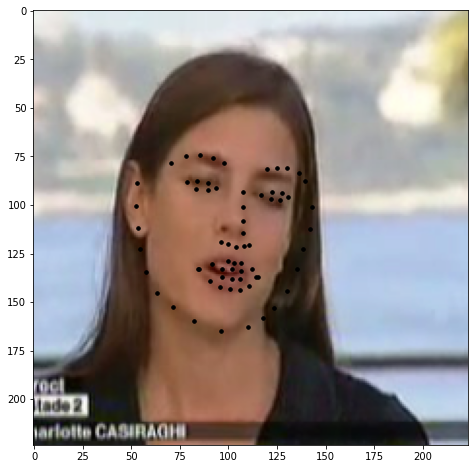

In [22]:
import numpy as np
from PIL import Image


def to_denorm_img(pic, mean, std):
    pic = np.transpose(pic, (1, 2, 0)).numpy() * std + mean
    pic = (pic * 255).astype('uint8')
    pic = Image.fromarray(pic)

    return pic

pic, _ = loaders['test'].dataset.__getitem__(105)
model.eval()
pic = pic.cpu()
model = model.cpu()
pred = model(pic.cpu().unsqueeze(0))

pic_mean = (0.485, 0.456, 0.406)
pic_std = (0.229, 0.224, 0.225)

pic = to_denorm_img(pic, pic_mean, pic_std)
pred = pred.squeeze(0).view(68, 2).detach().numpy()

show_keypoints(pic, pred, mean=mean, std=std)